In [4]:
import time
import os
import json
import boto3
import numpy as np  
import pandas as pd 
import sagemaker

sagemaker.__version__

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


'2.219.0'

In [5]:
!pip show sagemaker

Name: sagemaker
Version: 2.219.0
Summary: Open source library for training and deploying models on Amazon SageMaker.
Home-page: https://github.com/aws/sagemaker-python-sdk/
Author: Amazon Web Services
Author-email: 
License: Apache License 2.0
Location: /opt/conda/lib/python3.10/site-packages
Requires: attrs, boto3, cloudpickle, docker, google-pasta, importlib-metadata, jsonschema, numpy, packaging, pandas, pathos, platformdirs, protobuf, psutil, PyYAML, requests, schema, smdebug-rulesconfig, tblib, tqdm, urllib3
Required-by: 


In [5]:
boto_session = boto3.Session()
region = boto_session.region_name
bucket_name = sagemaker.Session().default_bucket()

In [6]:
bucket_prefix = "fire-project-hs"  
sm_session = sagemaker.Session()
sm_client = boto_session.client("sagemaker")
sm_role = sagemaker.get_execution_role()
#dataset_file_local_path = "data/bank-additional/bank-additional-full.csv"

In [12]:
sm_role

'arn:aws:iam::567821811420:role/service-role/AmazonSageMaker-ExecutionRole-20230619T084765'

In [ ]:
# %store bucket_name
# %store bucket_prefix
# %store sm_role
# %store region
# %store initialized
# %store dataset_file_local_path

In [7]:
NOTEBOOK_METADATA_FILE = "/opt/ml/metadata/resource-metadata.json"
domain_id = None

if os.path.exists(NOTEBOOK_METADATA_FILE):
    with open(NOTEBOOK_METADATA_FILE, "rb") as f:
        metadata = json.loads(f.read())
        domain_id = metadata.get('DomainId')
        user_profile_name = metadata.get('UserProfileName')
        print(f"SageMaker domain id: {domain_id}")
        print(user_profile_name)


SageMaker domain id: d-0xs1iibsib54
None


In [ ]:
# %store domain_id
# %store user_profile_name

**Data is in fire-project-hs bucket**

In [57]:
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

In [41]:
s3 = boto3.client('s3')

In [50]:
bucket_name = 'fire-project-hs'
object_key = 'fire-dataset-cl-1/fire_images/fire.80.png'

# Resmi S3't|en indir
s3_response = s3.get_object(Bucket=bucket_name, Key=object_key)

In [51]:
image_data = s3_response['Body'].read()

In [55]:
image = Image.open(BytesIO(image_data))

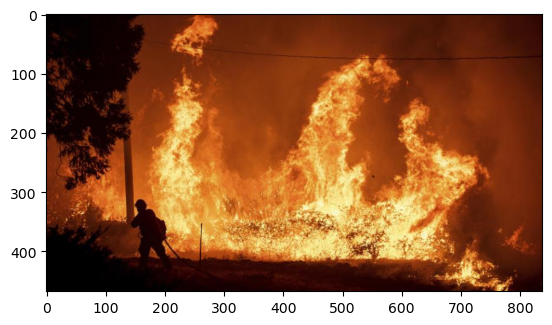

In [58]:
plt.imshow(image)   
plt.show()

**Taking Dataset from Feature Store**

In [8]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [9]:
from sagemaker.feature_store.feature_group import FeatureGroup

In [10]:
import sagemaker
from sagemaker.feature_store.feature_group import FeatureGroup

# Initialize the SageMaker session
# sagemaker_session = sm_session

# Define your feature group name and region
feature_group_name = 'fire-image-feature-group'
# region = 'your-aws-region'

# Initialize the feature group
feature_group = FeatureGroup(name=feature_group_name, sagemaker_session=sm_session)


In [22]:
# !pip install s3fs

In [11]:
import boto3
import pandas as pd

# Athena client
athena_client = boto3.client('athena', region_name=region)

# Query
# query = f"SELECT * FROM `{feature_group_name}`"
## Basic query to retrieve up to 1000 records from feature group

query = """SELECT *
FROM "AwsDataCatalog"."sagemaker_featurestore"."fire_image_feature_group_1718694943"
LIMIT 1000;"""

# Run query
response = athena_client.start_query_execution(
    QueryString=query,
    QueryExecutionContext={
        'Database': 'sagemaker_featurestore'  # Replace with your Athena database name
    },
    ResultConfiguration={
        'OutputLocation': 's3://wildfires/feature-store-output/'  # Replace with your S3 bucket
    }
)

# Get query execution ID
query_execution_id = response['QueryExecutionId']

# Wait for the query to complete
status = 'RUNNING'
while status != 'SUCCEEDED':
    response = athena_client.get_query_execution(QueryExecutionId=query_execution_id)
    status = response['QueryExecution']['Status']['State']

# Get the results
response = athena_client.get_query_results(QueryExecutionId=query_execution_id)

# Process the results into a DataFrame
rows = [row['Data'] for row in response['ResultSet']['Rows'][1:]]
columns = [col['VarCharValue'] for col in response['ResultSet']['Rows'][0]['Data']]
df = pd.DataFrame(rows, columns=columns)

print(df)



                                              image_id  \
0    {'VarCharValue': '11e0c2dc-a70f-47ea-9439-d579...   
1    {'VarCharValue': '3fcaee94-dd1c-4350-ace3-bbe7...   
2    {'VarCharValue': 'ece53839-d424-4234-8dbd-cb9e...   
3    {'VarCharValue': 'e367966d-3b98-4cd1-a78a-274f...   
4    {'VarCharValue': '18f69fe7-8267-4aff-8674-0409...   
..                                                 ...   
994  {'VarCharValue': '538312ca-6ecb-412c-a6f1-76bf...   
995  {'VarCharValue': 'e002f66b-83eb-4985-89d3-6ab3...   
996  {'VarCharValue': '67bb9a21-bf40-4a32-ba8b-ef3f...   
997  {'VarCharValue': '10e40f7c-bd73-4db1-8f05-2032...   
998  {'VarCharValue': 'ad38a230-b0cc-4165-88de-caf4...   

                                        image_location                  label  \
0    {'VarCharValue': 's3://wildfires/fire_images/f...  {'VarCharValue': '1'}   
1    {'VarCharValue': 's3://wildfires/fire_images/f...  {'VarCharValue': '1'}   
2    {'VarCharValue': 's3://wildfires/fire_images/f...  {'Va

In [12]:
import os
import requests

s3_client = boto3.client('s3')

def download_images(metadata, download_dir='images'):
    if not os.path.exists(download_dir):
        os.makedirs(download_dir)

    for record in metadata:
        image_location = record['image_location']
        bucket, key = image_location.replace('s3://', '').split('/', 1)
        local_path = os.path.join(download_dir, os.path.basename(key))
        
        s3_client.download_file(bucket, key, local_path)

        record['local_path'] = local_path  # Add the local path to the record

    return metadata

metadata = [
    {
        'image_id': row[0]['VarCharValue'],
        'image_location': row[1]['VarCharValue'],
        'label': int(row[2]['VarCharValue']),
        'image_type': row[3]['VarCharValue'],
        'event_time': row[4]['VarCharValue'],
    } for row in rows
]

metadata = download_images(metadata)


In [13]:
from sklearn.model_selection import train_test_split

# Split the metadata into train, validation, and test sets
train_metadata, test_metadata = train_test_split(metadata, test_size=0.2, stratify=[m['label'] for m in metadata], random_state=42)
train_metadata, val_metadata = train_test_split(train_metadata, test_size=0.25, stratify=[m['label'] for m in train_metadata], random_state=42)

print(f"Training samples: {len(train_metadata)}")
print(f"Validation samples: {len(val_metadata)}")
print(f"Test samples: {len(test_metadata)}")


Training samples: 599
Validation samples: 200
Test samples: 200


In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class FireDataset(Dataset):
    def __init__(self, metadata, transform=None):
        self.metadata = metadata
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_path = self.metadata[idx]['local_path']
        image = Image.open(img_path).convert('RGB')
        label = self.metadata[idx]['label']
        
        if self.transform:
            image = self.transform(image)

        return image, label


In [15]:
# Define transformations for training and validation/test datasets

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = FireDataset(train_metadata, transform=train_transform)
val_dataset = FireDataset(val_metadata, transform=val_test_transform)
test_dataset = FireDataset(test_metadata, transform=val_test_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [16]:
train_loader.__iter__().__next__()

[tensor([[[[ 0.9988,  0.9988,  0.9988,  ...,  1.1700,  1.2214,  1.3242],
           [ 0.9988,  0.9988,  0.9988,  ...,  1.2043,  1.2385,  1.3070],
           [ 0.9988,  0.9988,  0.9988,  ...,  1.1700,  1.2557,  1.3070],
           ...,
           [-0.1486, -0.0458, -0.0629,  ..., -0.1657, -0.2342, -0.2342],
           [-0.2171, -0.1314, -0.0458,  ..., -0.3027, -0.3027, -0.2684],
           [-0.1657, -0.1143, -0.2342,  ..., -0.2171, -0.4054, -0.3712]],
 
          [[ 1.2906,  1.2906,  1.2906,  ...,  1.4132,  1.4657,  1.5707],
           [ 1.2906,  1.2906,  1.2906,  ...,  1.4482,  1.4832,  1.5532],
           [ 1.2906,  1.2906,  1.2906,  ...,  1.4132,  1.5007,  1.5532],
           ...,
           [ 0.0476,  0.1702,  0.1877,  ...,  0.1352,  0.0651,  0.0126],
           [-0.0399,  0.1001,  0.2227,  ...,  0.0126,  0.0126, -0.0049],
           [ 0.0126,  0.1001,  0.0126,  ...,  0.1001, -0.0749, -0.0924]],
 
          [[ 1.5594,  1.5594,  1.5594,  ...,  1.5594,  1.6117,  1.7163],
           [ 

In [ ]:
# class CustomDataset(Dataset):
#     def __init__(self, dataframe, transform=None):
#         self.dataframe = dataframe
#         self.transform = transform

#     def __len__(self):
#         return len(self.dataframe)

#     def __getitem__(self, idx):
#         row = self.dataframe.iloc[idx]
#         image_data = io.BytesIO(row['image'])  # 'image' sütunu resmin bytes verisini içerir
#         image = Image.open(image_data).convert('RGB')

#         if self.transform:
#             image = self.transform(image)

#         label = row['label']  # 'label' sütunu resmin etiketini içerir
#         return image, label

# # Veri dönüşümleri (boyutlandırma, normalize etme)
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Özel veri setini oluştur
# custom_dataset = CustomDataset(dataframe=dataset, transform=transform)

# # Veri yükleyicisi oluştur
# batch_size = 32
# train_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)


In [ ]:
# class CustomDataset(Dataset):
#     def __init__(self, csv_file, root_dir, transform=None):
#         self.annotations = pd.read_csv(csv_file)
#         self.root_dir = root_dir
#         self.transform = transform

#     def __len__(self):
#         return len(self.annotations)

#     def __getitem__(self, idx):
#         img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
#         image = Image.open(img_name).convert("RGB")
#         label = self.annotations.iloc[idx, 1]
        
#         if self.transform:
#             image = self.transform(image)
        
#         return image, label


# transform = transforms.Compose([
#     # transforms.Resize((224, 224)),
#     transforms.ToTensor()
#     # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])
# dataset = CustomDataset(csv_file='path/to/metadata.csv', root_dir='path/to/images', transform=transform)


# train_loader = DataLoader(dataset, batch_size=32, shuffle=True)


# class_names = dataset.annotations['label'].unique()
# print(class_names)

**Model**

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import tqdm
from collections import defaultdict

In [18]:
model = models.resnet18(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [84]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

In [89]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [99]:
def train(model, train_loader, optimizer, criterion, epoch, device):
    model = model.to(device)
    model.train()
    train_loss = 0

    monitor = MetricMonitor()
    loss_function = criterion

    # stream = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        train_loss += loss.sum().item()
        loss.backward()
        optimizer.step()

        # logs
        monitor.update("loss", loss.item())
        # stream.set_description(
        #     "Epoch: {epoch}. {monitor}".format(epoch=epoch, monitor=monitor)
        # )

    return monitor

In [100]:
def test(model, test_loader, criterion, epoch, device):
    model = model.to(device)
    model.eval()

    monitor = MetricMonitor()
    loss_function = criterion

    # stream = tqdm(test_loader)
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)

            test_loss = loss_function(output, target).sum().item()
            pred = output.argmax(dim=1, keepdim=True)
            correct = pred.eq(target.view_as(pred)).sum().item()

            # logs
            monitor.update("test loss", test_loss)
            monitor.update("accuracy", correct / data.shape[0])
            # stream.set_description(
            #     "Epoch: {epoch}. {monitor}".format(epoch=epoch, monitor=monitor)
            # )

    return monitor

In [22]:
def train(model, train_loader, optimizer, loss_function, epoch, device):
    model = model.to(device)
    loss_function = loss_function.to(device)
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        train_loss += loss.sum().item()
        loss.backward()
        optimizer.step()
        # state = {"model_state": model.state_dict(),
        #      "optimizer_state": optimizer.state_dict(),
        #      "epoch": epoch}
        # torch.save(state, f"{checkpoint_dir}/epoch_{epoch}.pth")
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    train_loss /= len(train_loader.dataset)
    # writer.add_scalar("train-loss", train_loss, global_step=epoch)

def test(model, test_loader, loss_function, epoch, device):
    model = model.to(device)
    loss_function = loss_function.to(device)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            test_loss += loss_function(output, target).sum().item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    # writer.add_scalar("test-loss", test_loss, global_step=epoch)
    # writer.add_scalar("test-accuracy", 100. * correct / len(test_loader.dataset), global_step=epoch)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [23]:
def train_test(model, optimizer, train_loader, test_loader, device, n_epochs=1):
    for epoch in range(0, n_epochs):
        train(model, train_loader, optimizer, criterion, epoch, device)
        test(model, test_loader, criterion, epoch, device)

In [24]:
train_test(model=model,
           optimizer=optimizer,
           train_loader=train_loader,
           test_loader=test_loader,
           device=device,
           n_epochs=10 # around 15 epochs is enouch
           )


Train Epoch: 0 [0/599 (0%)]	Loss: 0.788508


KeyboardInterrupt: 

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
device

device(type='cpu')

In [16]:
import time
import os
import json
import boto3
import numpy as np  
import pandas as pd 
import sagemaker

sagemaker.__version__

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


'2.219.0'

In [5]:
!pip show sagemaker

Name: sagemaker
Version: 2.219.0
Summary: Open source library for training and deploying models on Amazon SageMaker.
Home-page: https://github.com/aws/sagemaker-python-sdk/
Author: Amazon Web Services
Author-email: 
License: Apache License 2.0
Location: /opt/conda/lib/python3.10/site-packages
Requires: attrs, boto3, cloudpickle, docker, google-pasta, importlib-metadata, jsonschema, numpy, packaging, pandas, pathos, platformdirs, protobuf, psutil, PyYAML, requests, schema, smdebug-rulesconfig, tblib, tqdm, urllib3
Required-by: 


In [5]:
boto_session = boto3.Session()
region = boto_session.region_name
bucket_name = sagemaker.Session().default_bucket()

In [6]:
bucket_prefix = "fire-project-hs"  
sm_session = sagemaker.Session()
sm_client = boto_session.client("sagemaker")
sm_role = sagemaker.get_execution_role()
#dataset_file_local_path = "data/bank-additional/bank-additional-full.csv"

In [12]:
sm_role

'arn:aws:iam::567821811420:role/service-role/AmazonSageMaker-ExecutionRole-20230619T084765'

In [ ]:
# %store bucket_name
# %store bucket_prefix
# %store sm_role
# %store region
# %store initialized
# %store dataset_file_local_path

In [7]:
NOTEBOOK_METADATA_FILE = "/opt/ml/metadata/resource-metadata.json"
domain_id = None

if os.path.exists(NOTEBOOK_METADATA_FILE):
    with open(NOTEBOOK_METADATA_FILE, "rb") as f:
        metadata = json.loads(f.read())
        domain_id = metadata.get('DomainId')
        user_profile_name = metadata.get('UserProfileName')
        print(f"SageMaker domain id: {domain_id}")
        print(user_profile_name)


SageMaker domain id: d-0xs1iibsib54
None


In [ ]:
# %store domain_id
# %store user_profile_name

**Data is in fire-project-hs bucket**

In [57]:
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

In [41]:
s3 = boto3.client('s3')

In [50]:
bucket_name = 'fire-project-hs'
object_key = 'fire-dataset-cl-1/fire_images/fire.80.png'

# Resmi S3't|en indir
s3_response = s3.get_object(Bucket=bucket_name, Key=object_key)

In [51]:
image_data = s3_response['Body'].read()

In [55]:
image = Image.open(BytesIO(image_data))

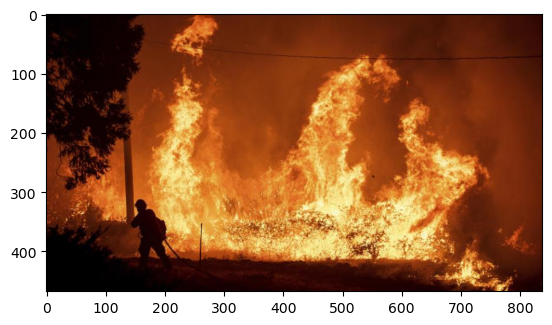

In [58]:
plt.imshow(image)   
plt.show()

**Taking Dataset from Feature Store**

In [8]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [9]:
from sagemaker.feature_store.feature_group import FeatureGroup

In [10]:
import sagemaker
from sagemaker.feature_store.feature_group import FeatureGroup

# Initialize the SageMaker session
# sagemaker_session = sm_session

# Define your feature group name and region
feature_group_name = 'fire-image-feature-group'
# region = 'your-aws-region'

# Initialize the feature group
feature_group = FeatureGroup(name=feature_group_name, sagemaker_session=sm_session)


In [22]:
# !pip install s3fs

In [11]:
import boto3
import pandas as pd

# Athena client
athena_client = boto3.client('athena', region_name=region)

# Query
# query = f"SELECT * FROM `{feature_group_name}`"
## Basic query to retrieve up to 1000 records from feature group

query = """SELECT *
FROM "AwsDataCatalog"."sagemaker_featurestore"."fire_image_feature_group_1718694943"
LIMIT 1000;"""

# Run query
response = athena_client.start_query_execution(
    QueryString=query,
    QueryExecutionContext={
        'Database': 'sagemaker_featurestore'  # Replace with your Athena database name
    },
    ResultConfiguration={
        'OutputLocation': 's3://wildfires/feature-store-output/'  # Replace with your S3 bucket
    }
)

# Get query execution ID
query_execution_id = response['QueryExecutionId']

# Wait for the query to complete
status = 'RUNNING'
while status != 'SUCCEEDED':
    response = athena_client.get_query_execution(QueryExecutionId=query_execution_id)
    status = response['QueryExecution']['Status']['State']

# Get the results
response = athena_client.get_query_results(QueryExecutionId=query_execution_id)

# Process the results into a DataFrame
rows = [row['Data'] for row in response['ResultSet']['Rows'][1:]]
columns = [col['VarCharValue'] for col in response['ResultSet']['Rows'][0]['Data']]
df = pd.DataFrame(rows, columns=columns)

print(df)



                                              image_id  \
0    {'VarCharValue': '11e0c2dc-a70f-47ea-9439-d579...   
1    {'VarCharValue': '3fcaee94-dd1c-4350-ace3-bbe7...   
2    {'VarCharValue': 'ece53839-d424-4234-8dbd-cb9e...   
3    {'VarCharValue': 'e367966d-3b98-4cd1-a78a-274f...   
4    {'VarCharValue': '18f69fe7-8267-4aff-8674-0409...   
..                                                 ...   
994  {'VarCharValue': '538312ca-6ecb-412c-a6f1-76bf...   
995  {'VarCharValue': 'e002f66b-83eb-4985-89d3-6ab3...   
996  {'VarCharValue': '67bb9a21-bf40-4a32-ba8b-ef3f...   
997  {'VarCharValue': '10e40f7c-bd73-4db1-8f05-2032...   
998  {'VarCharValue': 'ad38a230-b0cc-4165-88de-caf4...   

                                        image_location                  label  \
0    {'VarCharValue': 's3://wildfires/fire_images/f...  {'VarCharValue': '1'}   
1    {'VarCharValue': 's3://wildfires/fire_images/f...  {'VarCharValue': '1'}   
2    {'VarCharValue': 's3://wildfires/fire_images/f...  {'Va

In [12]:
import os
import requests

s3_client = boto3.client('s3')

def download_images(metadata, download_dir='images'):
    if not os.path.exists(download_dir):
        os.makedirs(download_dir)

    for record in metadata:
        image_location = record['image_location']
        bucket, key = image_location.replace('s3://', '').split('/', 1)
        local_path = os.path.join(download_dir, os.path.basename(key))
        
        s3_client.download_file(bucket, key, local_path)

        record['local_path'] = local_path  # Add the local path to the record

    return metadata

metadata = [
    {
        'image_id': row[0]['VarCharValue'],
        'image_location': row[1]['VarCharValue'],
        'label': int(row[2]['VarCharValue']),
        'image_type': row[3]['VarCharValue'],
        'event_time': row[4]['VarCharValue'],
    } for row in rows
]

metadata = download_images(metadata)


In [13]:
from sklearn.model_selection import train_test_split

# Split the metadata into train, validation, and test sets
train_metadata, test_metadata = train_test_split(metadata, test_size=0.2, stratify=[m['label'] for m in metadata], random_state=42)
train_metadata, val_metadata = train_test_split(train_metadata, test_size=0.25, stratify=[m['label'] for m in train_metadata], random_state=42)

print(f"Training samples: {len(train_metadata)}")
print(f"Validation samples: {len(val_metadata)}")
print(f"Test samples: {len(test_metadata)}")


Training samples: 599
Validation samples: 200
Test samples: 200


In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class FireDataset(Dataset):
    def __init__(self, metadata, transform=None):
        self.metadata = metadata
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_path = self.metadata[idx]['local_path']
        image = Image.open(img_path).convert('RGB')
        label = self.metadata[idx]['label']
        
        if self.transform:
            image = self.transform(image)

        return image, label


In [15]:
# Define transformations for training and validation/test datasets

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = FireDataset(train_metadata, transform=train_transform)
val_dataset = FireDataset(val_metadata, transform=val_test_transform)
test_dataset = FireDataset(test_metadata, transform=val_test_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [1]:
# train_loader.__iter__().__next__()

In [ ]:
# class CustomDataset(Dataset):
#     def __init__(self, dataframe, transform=None):
#         self.dataframe = dataframe
#         self.transform = transform

#     def __len__(self):
#         return len(self.dataframe)

#     def __getitem__(self, idx):
#         row = self.dataframe.iloc[idx]
#         image_data = io.BytesIO(row['image'])  # 'image' sütunu resmin bytes verisini içerir
#         image = Image.open(image_data).convert('RGB')

#         if self.transform:
#             image = self.transform(image)

#         label = row['label']  # 'label' sütunu resmin etiketini içerir
#         return image, label

# # Veri dönüşümleri (boyutlandırma, normalize etme)
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Özel veri setini oluştur
# custom_dataset = CustomDataset(dataframe=dataset, transform=transform)

# # Veri yükleyicisi oluştur
# batch_size = 32
# train_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)


In [ ]:
# class CustomDataset(Dataset):
#     def __init__(self, csv_file, root_dir, transform=None):
#         self.annotations = pd.read_csv(csv_file)
#         self.root_dir = root_dir
#         self.transform = transform

#     def __len__(self):
#         return len(self.annotations)

#     def __getitem__(self, idx):
#         img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
#         image = Image.open(img_name).convert("RGB")
#         label = self.annotations.iloc[idx, 1]
        
#         if self.transform:
#             image = self.transform(image)
        
#         return image, label


# transform = transforms.Compose([
#     # transforms.Resize((224, 224)),
#     transforms.ToTensor()
#     # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])
# dataset = CustomDataset(csv_file='path/to/metadata.csv', root_dir='path/to/images', transform=transform)


# train_loader = DataLoader(dataset, batch_size=32, shuffle=True)


# class_names = dataset.annotations['label'].unique()
# print(class_names)

**Model**

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import tqdm
from collections import defaultdict

In [5]:
model = models.resnet18(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

In [89]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [99]:
def train(model, train_loader, optimizer, criterion, epoch, device):
    model = model.to(device)
    model.train()
    train_loss = 0

    monitor = MetricMonitor()
    loss_function = criterion

    # stream = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        train_loss += loss.sum().item()
        loss.backward()
        optimizer.step()

        # logs
        monitor.update("loss", loss.item())
        # stream.set_description(
        #     "Epoch: {epoch}. {monitor}".format(epoch=epoch, monitor=monitor)
        # )

    return monitor

In [100]:
def test(model, test_loader, criterion, epoch, device):
    model = model.to(device)
    model.eval()

    monitor = MetricMonitor()
    loss_function = criterion

    # stream = tqdm(test_loader)
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)

            test_loss = loss_function(output, target).sum().item()
            pred = output.argmax(dim=1, keepdim=True)
            correct = pred.eq(target.view_as(pred)).sum().item()

            # logs
            monitor.update("test loss", test_loss)
            monitor.update("accuracy", correct / data.shape[0])
            # stream.set_description(
            #     "Epoch: {epoch}. {monitor}".format(epoch=epoch, monitor=monitor)
            # )

    return monitor

In [22]:
def train(model, train_loader, optimizer, loss_function, epoch, device):
    model = model.to(device)
    loss_function = loss_function.to(device)
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        train_loss += loss.sum().item()
        loss.backward()
        optimizer.step()
        # state = {"model_state": model.state_dict(),
        #      "optimizer_state": optimizer.state_dict(),
        #      "epoch": epoch}
        # torch.save(state, f"{checkpoint_dir}/epoch_{epoch}.pth")
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    train_loss /= len(train_loader.dataset)
    # writer.add_scalar("train-loss", train_loss, global_step=epoch)

def test(model, test_loader, loss_function, epoch, device):
    model = model.to(device)
    loss_function = loss_function.to(device)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            test_loss += loss_function(output, target).sum().item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    # writer.add_scalar("test-loss", test_loss, global_step=epoch)
    # writer.add_scalar("test-accuracy", 100. * correct / len(test_loader.dataset), global_step=epoch)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [23]:
def train_test(model, optimizer, train_loader, test_loader, device, n_epochs=1):
    for epoch in range(0, n_epochs):
        train(model, train_loader, optimizer, criterion, epoch, device)
        test(model, test_loader, criterion, epoch, device)

In [24]:
train_test(model=model,
           optimizer=optimizer,
           train_loader=train_loader,
           test_loader=test_loader,
           device=device,
           n_epochs=10 # around 15 epochs is enouch
           )


Train Epoch: 0 [0/599 (0%)]	Loss: 0.788508


KeyboardInterrupt: 

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
device

device(type='cpu')

**Saving Model**

In [3]:
import torch
import torchvision.models as models

In [2]:
model_filename = "model_resnet18"
model_folder = "models"

In [1]:
%mkdir -p models

In [9]:
torch.save(model.state_dict(), f'{model_folder}/{model_filename}.pth')

In [12]:
import tarfile

# model.save_model(f"../{model_folder}/{model_filename}")

with tarfile.open(f"{model_folder}/{model_filename}.tar.gz", "w:gz") as tar:
    tar.add(f'{model_folder}/{model_filename}.pth', arcname=model_filename)

In [ ]:
# bst.save_model(f"../models/{model_filename}")

In [48]:
s3 = boto3.client('s3')

In [49]:
BUCKET_NAME = 'wildfires'

In [50]:
s3.upload_file(
    f'{model_folder}/{model_filename}.tar.gz',
    BUCKET_NAME,
    f"models/{model_filename}.tar.gz",
)

**Deploy Model**

In [51]:
import sagemaker
import boto3
from sagemaker.inputs import CreateModelInput
from sagemaker.xgboost import XGBoostModel
from sagemaker import image_uris
# from sagemaker.pytorch import PyTorchModel

In [52]:
torch.__version__

'2.0.0.post104'

In [53]:
# !pip install --upgrade sagemaker

In [54]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
# BUCKET_NAME = "team1-index-predictor-bucket"
model_path = f"models/{model_filename}.tar.gz"

In [57]:
model_container = image_uris.retrieve(
    "pytorch", 
    sagemaker_session.boto_region_name, 
    version="1.8", 
    image_scope='inference',
    instance_type='ml.t2.large',
    py_version='py3')

model = sagemaker.model.Model(
    image_uri=model_container,
    model_data=f"s3://{BUCKET_NAME}/{model_path}",
    role=role,
    sagemaker_session=sagemaker_session
)

In [58]:
predictor = model.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.large'
)

--------!

**Inference**

In [ ]:
import pandas as pd
import boto3
import json
import numpy as np

In [83]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import io

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


def preprocess_image(img_path, transform):
    image = Image.open(img_path).convert('RGB')
    image = transform(image)

    image = image.unsqueeze(0)
    return image

image_path = 'test_data_1.png'
input_data = preprocess_image(image_path, val_test_transform)

input_data_np = input_data.numpy()

input_data_bytes = input_data_np.tobytes()


In [84]:
# input_data_bytes

In [85]:
runtime_client = boto3.client("sagemaker-runtime")

endpoint_name = "pytorch-inference-2024-06-18-13-46-45-456"

In [ ]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer


predictor = Predictor(
    endpoint_name=endpoint_name,
    sagemaker_session=sagemaker_session,
    serializer=IdentitySerializer("application/x-npy"),
    deserializer=JSONDeserializer()
)

# Prediction
prediction = predictor.predict(input_data_bytes)
print(prediction)